In [1]:
import shaqodoon_forecasting as sf

TRAIN_TEST_DATE_SPLIT = sf.settings.TRAIN_TEST_DATE_SPLIT
TEST_DATE_END = sf.settings.TEST_DATE_END

STATION_LAG_DAYS = sf.settings.STATION_LAG_DAYS
WEATHER_LAG_DAYS = sf.settings.WEATHER_LAG_DAYS

In [2]:
import pandas as pd

df = pd.read_csv("data/interim/bulo_burti_001-1.csv")
df.head()

,ds,level__m,lag1_level__m,lag3_level__m,lag7_level__m,lag14_level__m,belet_weyne_lag1_level__m,belet_weyne_lag3_level__m,belet_weyne_lag7_level__m,belet_weyne_lag14_level__m,...,ethiopia_shabelle_gode_lag7_precipitation_hours,ethiopia_shabelle_gode_lag14_precipitation_sum,ethiopia_shabelle_gode_lag14_precipitation_hours,ethiopia_shabelle_gode_forecast1_precipitation_sum,ethiopia_shabelle_gode_forecast1_precipitation_hours,ethiopia_shabelle_gode_forecast3_precipitation_sum,ethiopia_shabelle_gode_forecast3_precipitation_hours,ethiopia_shabelle_gode_forecast7_precipitation_sum,ethiopia_shabelle_gode_forecast7_precipitation_hours,y
0,2021-11-24,2.48,2.51,2.60,2.78,3.42,3.30,3.45,3.85,4.45,...,3.0,0.0,0.0,0.000000,0.0,0.4,3.0,0.0,0.0,-0.03
1,2021-11-25,2.45,2.48,2.55,2.74,3.30,3.24,3.38,3.66,4.38,...,0.0,0.0,0.0,19.900002,7.0,0.1,1.0,0.0,0.0,-0.03
2,2021-11-26,2.40,2.45,2.51,2.69,3.22,3.20,3.30,3.66,4.38,...,0.0,0.0,0.0,0.400000,3.0,0.0,0.0,0.0,0.0,-0.05
3,2021-11-27,2.36,2.40,2.48,2.66,3.11,3.10,3.24,3.55,4.27,...,0.0,0.8,2.0,0.100000,1.0,0.0,0.0,0.0,0.0,-0.04
4,2021-11-28,2.30,2.36,2.45,2.60,3.02,3.10,3.20,3.45,4.18,...,0.0,0.1,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.06


In [8]:
df["month"] = df["ds"].str[5:7]
df["day"] = df["ds"].str[8:10]

In [9]:
train_df, test_df = (
    df[(df["ds"] < TRAIN_TEST_DATE_SPLIT)],
    df[(df["ds"] >= TRAIN_TEST_DATE_SPLIT)]
)

# add buffer for lag
test_df = test_df.iloc[max([max(STATION_LAG_DAYS), max(WEATHER_LAG_DAYS)]):, :]

# zoom on time frame
if TEST_DATE_END:
    test_df = test_df[test_df["ds"] <= TEST_DATE_END]

{
    "train_df": (train_df["ds"].min(), train_df["ds"].max()), 
    "test_df": (test_df["ds"].min(), test_df["ds"].max())
}

{'train_df': ('2021-11-24', '2023-09-30'),
 'test_df': ('2023-10-15', '2024-11-18')}

In [15]:
# FIXME: QUICKFIX to avoid error
count_test_df_raw = len(test_df.index)
test_df = test_df.dropna()
count_test_df_no_na = len(test_df.index)
print(f"drop NA rows effect: {count_test_df_no_na}/{count_test_df_raw} ({count_test_df_no_na/count_test_df_raw:.2%})")

drop NA rows effect: 391/400 (97.75%)


In [16]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(max_depth=3, random_state=0)

train_X = train_df[[c for c in train_df.columns if c not in ["y", "ds", "level__m"]]]
train_y = train_df["y"]
clf.fit(train_X, train_y)

RandomForestRegressor(max_depth=3, random_state=0)

In [17]:
test_X = test_df[[c for c in test_df.columns if c not in ["y", "ds", "level__m"]]]
test_y = test_df["y"]

In [24]:
pred_y = clf.predict(test_X.dropna())

eval_df = pd.DataFrame({
    "ds": test_df["ds"],
    "pred_y": pred_y,
    "test_y": test_y,
    "level__m": test_df["level__m"],
    "abs_pred_y": test_df["level__m"] + pred_y,
    "abs_test_y": test_df["level__m"] + test_y,
})

eval_df.head()


,ds,pred_y,test_y,level__m,abs_pred_y,abs_test_y
644,2023-10-15,-0.020952,-0.28,5.24,5.219048,4.96
645,2023-10-16,-0.026450,-0.06,5.18,5.153550,5.12
646,2023-10-17,-0.009300,-0.10,5.08,5.070700,4.98
647,2023-10-18,-0.014378,-0.08,5.00,4.985622,4.92
648,2023-10-19,-0.029190,-0.10,4.90,4.870810,4.80


(0.0, 9.0)

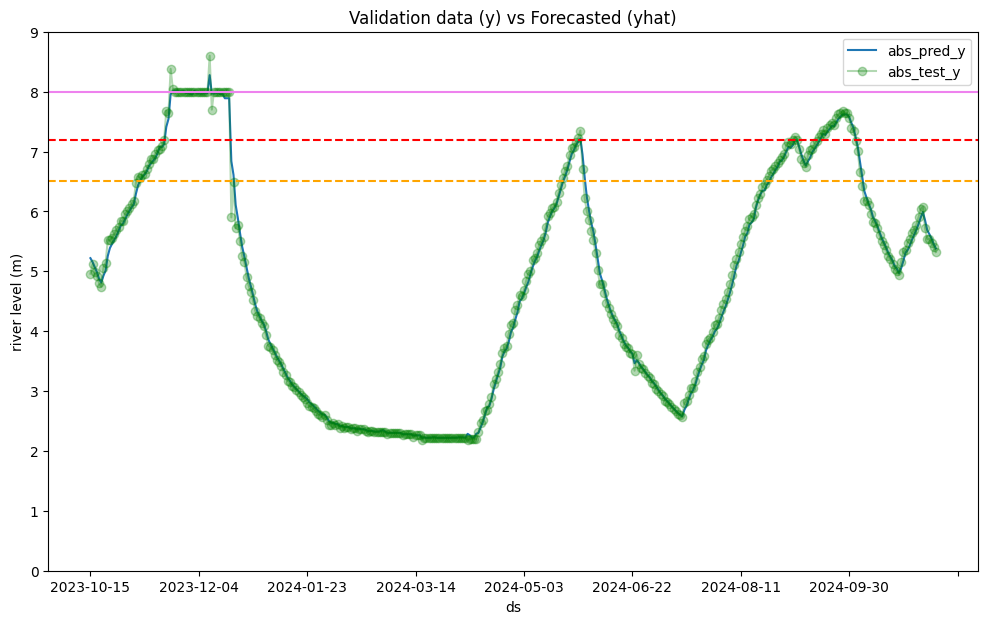

In [ ]:
import matplotlib.pyplot as plt

df = eval_df

fig, ax = plt.subplots(1, 1, figsize=(12,7))
ax.set_title("Validation data (y) vs Forecasted (yhat)")
df.plot(x="ds", y="abs_pred_y", ax=ax)
df.plot(x="ds", y="abs_test_y", ax=ax, color='green', alpha=0.3, marker='o')
ax.set_ylabel("river level (m)")
ax.axhline(y=6.5, color='orange', linestyle='--')
ax.axhline(y=7.2, color='red', linestyle='--')
ax.axhline(y=8, color='violet', linestyle='-')
ax.set_ylim([0, 9])
pass

## Focus On Peaks

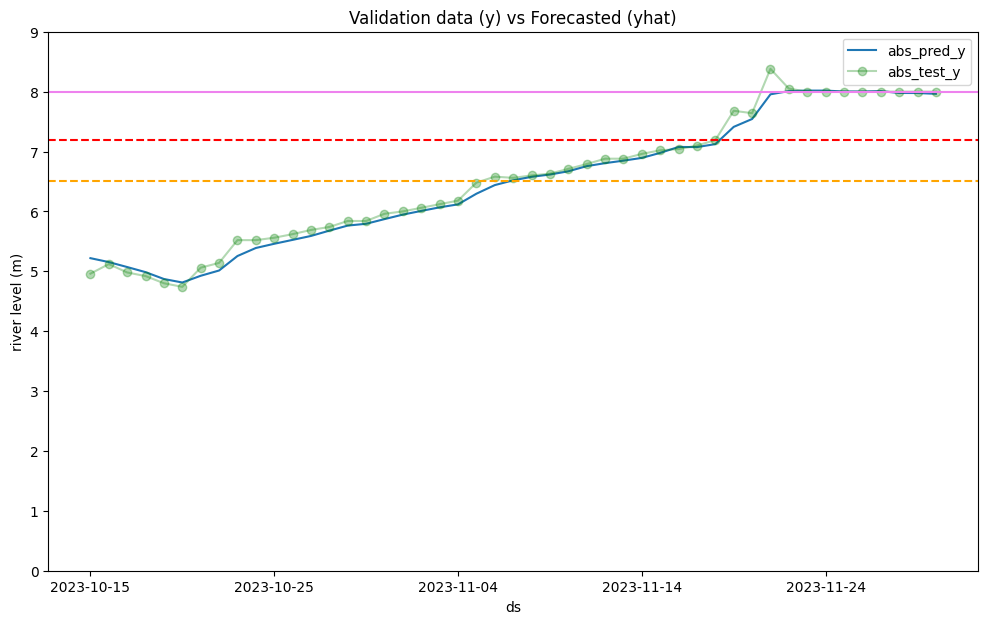

In [31]:
import matplotlib.pyplot as plt

df = eval_df[eval_df["ds"] < "2023-12"]

fig, ax = plt.subplots(1, 1, figsize=(12,7))
ax.set_title("Validation data (y) vs Forecasted (yhat)")
df.plot(x="ds", y="abs_pred_y", ax=ax)
df.plot(x="ds", y="abs_test_y", ax=ax, color='green', alpha=0.3, marker='o')
ax.set_ylabel("river level (m)")
ax.axhline(y=6.5, color='orange', linestyle='--')
ax.axhline(y=7.2, color='red', linestyle='--')
ax.axhline(y=8, color='violet', linestyle='-')
ax.set_ylim([0, 9])
pass

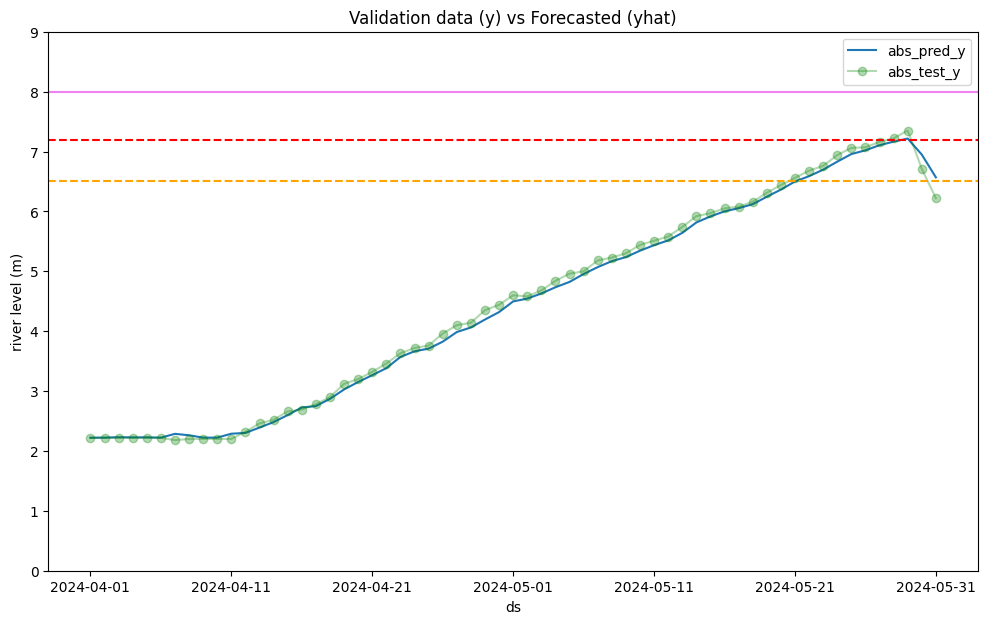

In [32]:
import matplotlib.pyplot as plt

df = eval_df[(eval_df["ds"] >= "2024-04") & (eval_df["ds"] < "2024-06")]

fig, ax = plt.subplots(1, 1, figsize=(12,7))
ax.set_title("Validation data (y) vs Forecasted (yhat)")
df.plot(x="ds", y="abs_pred_y", ax=ax)
df.plot(x="ds", y="abs_test_y", ax=ax, color='green', alpha=0.3, marker='o')
ax.set_ylabel("river level (m)")
ax.axhline(y=6.5, color='orange', linestyle='--')
ax.axhline(y=7.2, color='red', linestyle='--')
ax.axhline(y=8, color='violet', linestyle='-')
ax.set_ylim([0, 9])
pass

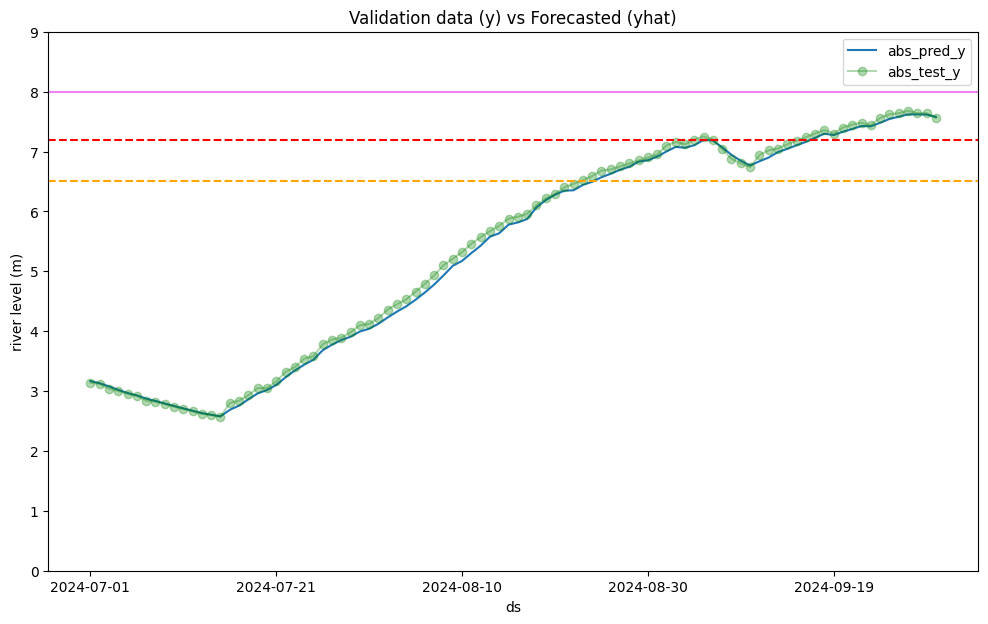

In [33]:
import matplotlib.pyplot as plt

df = eval_df[(eval_df["ds"] >= "2024-07") & (eval_df["ds"] < "2024-10")]

fig, ax = plt.subplots(1, 1, figsize=(12,7))
ax.set_title("Validation data (y) vs Forecasted (yhat)")
df.plot(x="ds", y="abs_pred_y", ax=ax)
df.plot(x="ds", y="abs_test_y", ax=ax, color='green', alpha=0.3, marker='o')
ax.set_ylabel("river level (m)")
ax.axhline(y=6.5, color='orange', linestyle='--')
ax.axhline(y=7.2, color='red', linestyle='--')
ax.axhline(y=8, color='violet', linestyle='-')
ax.set_ylim([0, 9])
pass

In [30]:
list(sorted(zip(train_X.columns, clf.feature_importances_), key=lambda t: t[1], reverse=True))

[('lag14_level__m', 0.11467928339783366),
 ('belet_weyne_lag1_level__m', 0.11200971314646406),
 ('belet_weyne_lag14_level__m', 0.11141295912845926),
 ('ethiopia_tullu_dimtu_lag14_precipitation_sum', 0.08998676394849171),
 ('belet_weyne_lag3_level__m', 0.06632021164657062),
 ('lag7_level__m', 0.05319828096894321),
 ('ethiopia_shabelle_gode_lag14_precipitation_hours', 0.0521507082100589),
 ('ethiopia_fafen_haren_forecast1_precipitation_hours', 0.04414899783068584),
 ('month', 0.03576723574890522),
 ('ethiopia_shabelle_gode_lag3_precipitation_hours', 0.029288160150014054),
 ('ethiopia_shabelle_gode_lag7_precipitation_hours', 0.02774865301241335),
 ('lag1_level__m', 0.025234288771893893),
 ('ethiopia_shabelle_gode_lag14_precipitation_sum', 0.025155502047090456),
 ('lag3_level__m', 0.022113237233801306),
 ('ethiopia_fafen_gebredarre_forecast1_precipitation_hours',
  0.019814675218367623),
 ('ethiopia_fafen_gebredarre_lag14_precipitation_sum', 0.01748164927427921),
 ('ethiopia_fafen_haren_la

In [34]:
f"RMSE: {((eval_df.abs_pred_y - eval_df.abs_test_y) ** 2).mean() ** .5:.4} meters"

'RMSE: 0.09859 meters'

In [40]:
# Baseline: forecasting the level of the previous day
f"RMSE BASELINE: {((test_df.lag1_level__m - test_df.level__m) ** 2).mean() ** .5:.4} meters"

'RMSE BASELINE: 0.1146 meters'